In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import warnings
warnings.filterwarnings("ignore")

In [2]:
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c',
    password='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password',
    database='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db'
)

In [4]:
# Changed

query1=''' 
    select o.id as order_id,
    o.created_at::date as order_date,
    o.email as user_id,
    o.total_line_items_price as MRP,
    o.total_discounts as discount_amount,
    total_price as total_price
    
    from orders o
    WHERE
    cancelled_at is NULL;
'''
query2=''' 
    select oli.order_id as order_id,
    oli.product_id as product_id,
    oli.name as product_name,
    oli.quantity as quantity,
    oli.price as sp
    from order_line_item oli;
'''

In [5]:
# Changed

o=pd.read_sql(query1,conn)
r=pd.read_sql(query2,conn)

In [6]:
# Changed

data=pd.merge(o,r,on='order_id',how='left')
data['order_date']=pd.to_datetime(data['order_date'])

In [7]:
#New/Repeat Tag
# data = data[data['order_date'] >= '2022-12-25']
# data=data[data['order_date'] <= '2023-12-25']

orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel





data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()

In [8]:
# Changed
data['discount_ratio'] = data['discount_amount']/data['mrp']
data['new_ordervalue']= data['ordervalue']-(data['ordervalue']*data['discount_ratio'])

In [9]:
totalcarts=data['order_id'].nunique()
product_level=data.groupby(['product_id',"product_name"]).agg(
        Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
        ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
        NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
        RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
        Customers=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
        Total_Order_Value=pd.NamedAgg(column='new_ordervalue', aggfunc='sum'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique')
).reset_index()

In [10]:
# Changed
data_new=data[data['TrxnRank']==1]

xuser_count = data_new.groupby(['product_id',"product_name"]).agg(
    acquired_pool = pd.NamedAgg(column = "user_id", aggfunc = 'nunique'),
    x_user_list = pd.NamedAgg(column = "user_id", aggfunc = lambda x: [x.unique()])
).reset_index()

data_repeat=data[data['TrxnRank']==2]
repeat_users=data_repeat['user_id'].to_list()

l=[]
for i in range (len(xuser_count)):
    a=(xuser_count.iloc[i,3])[0]
    b=[x for x in a if x in repeat_users]
    l.append(len(b))

xuser_count['repeat_pool']=l
xuser_count['Conversion_Rate'] = xuser_count['repeat_pool']/xuser_count['acquired_pool']

conversion_result = xuser_count.copy()

In [11]:
# Changed
conversion_result.drop(columns=['x_user_list'], inplace=True)
conversion_result

,product_id,product_name,acquired_pool,repeat_pool,Conversion_Rate
0,5.320060e+12,Thogarihunkal Estate Coffee - Aeropress / 250 gm,17,9,0.529412
1,5.320060e+12,Thogarihunkal Estate Coffee - Cold Brew / 250 gm,6,2,0.333333
2,5.320060e+12,Thogarihunkal Estate Coffee - Decoction Coffee...,14,7,0.500000
3,5.320060e+12,Thogarihunkal Estate Coffee - Decoction Coffee...,1,0,0.000000
4,5.320060e+12,Thogarihunkal Estate Coffee - Espresso / 1000 gm,1,0,0.000000
...,...,...,...,...,...
801,7.742866e+12,South Indian Traditional Filter Coffee - Dark ...,15,3,0.200000
802,7.792635e+12,Brazil & Ethiopia Speciality Instant Coffee (P...,4,0,0.000000
803,7.792637e+12,Colombia & Ethiopia Speciality Instant Coffee ...,2,1,0.500000
804,7.792641e+12,Brazil & Colombia Speciality Instant Coffee (P...,3,0,0.000000


In [12]:
# Changed
productlevel=pd.merge(product_level,conversion_result,on=['product_name','product_id'], how='left')
productlevel

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Customers,AOVContribution,Total_Order_Value,Order_Count,acquired_pool,repeat_pool,Conversion_Rate
0,5.320060e+12,Thogarihunkal Estate Coffee - Aeropress / 250 gm,27,27,566.148148,17,10,27,0.209604,9374.588706,27,17.0,9.0,0.529412
1,5.320060e+12,Thogarihunkal Estate Coffee - Chemex / 250 gm,1,1,585.000000,0,1,1,0.008022,301.519824,1,NaN,NaN,NaN
2,5.320060e+12,Thogarihunkal Estate Coffee - Cold Brew / 250 gm,20,21,574.190476,7,14,9,0.165341,7902.928571,20,6.0,2.0,0.333333
3,5.320060e+12,Thogarihunkal Estate Coffee - Cold Brew / 500 gm,1,1,936.000000,0,1,1,0.012835,663.906977,1,NaN,NaN,NaN
4,5.320060e+12,Thogarihunkal Estate Coffee - Decoction Coffee...,22,23,580.000000,14,8,21,0.182989,8030.703009,22,14.0,7.0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,7.792635e+12,Brazil & Ethiopia Speciality Instant Coffee (P...,7,8,548.000000,4,3,6,0.063542,3528.982267,7,4.0,0.0,0.000000
913,7.792637e+12,Colombia & Ethiopia Speciality Instant Coffee ...,1,1,748.000000,0,1,1,0.010257,748.000000,1,NaN,NaN,NaN
914,7.792637e+12,Colombia & Ethiopia Speciality Instant Coffee ...,4,4,648.000000,2,2,4,0.035542,2592.000000,4,2.0,1.0,0.500000
915,7.792641e+12,Brazil & Colombia Speciality Instant Coffee (P...,4,5,698.000000,3,1,4,0.047855,3490.000000,4,3.0,0.0,0.000000


In [13]:
# Changed
productlevel['NewRepeatConversionRatio']=productlevel['Conversion_Rate']
productlevel['NewRepeatConversionRatio']=productlevel['NewRepeatConversionRatio'].fillna(0)
productlevel=productlevel.sort_values('NewRepeatConversionRatio')
productlevel['CartPenetration']=productlevel['Carts']/totalcarts
productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

In [14]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)

In [15]:
# Changed

CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels))#.astype('int64')
productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
# productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
# productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
def ProductCohortLables2(df):
    if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
        return 'Hero Products'
    elif df['NewRepeatConversion_score'] >2:
        return 'High Repeat Products'
    elif (df['CP_score'] >2):
        return 'New Business Products'
    elif (df['ASP_score'] >3):
        return 'High Value & Slow Moving Products'
    elif (df['ASP_score'] <=3):
        return 'Low Value & Slow Moving Products'
    else:
        return 'Low Value & Slow Moving Products'
productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)

In [16]:
productlevel#.columns

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Customers,AOVContribution,Total_Order_Value,...,repeat_pool,Conversion_Rate,NewRepeatConversionRatio,CartPenetration,QpC,ASPXQpC,CP_score,NewRepeatConversion_score,ASP_score,Product Cohort Lables
916,7.792641e+12,Brazil & Colombia Speciality Instant Coffee (P...,4,4,760.500000,2,2,4,0.041712,2244.185414,...,0.0,0.0,0.0,0.000055,1.0,760.500000,2,1,2,Low Value & Slow Moving Products
700,6.603460e+12,Aerolatte Steam Free Milk Frother With Stand -...,6,6,2016.666667,3,3,6,0.165917,11177.539273,...,0.0,0.0,0.0,0.000082,1.0,2016.666667,2,1,4,High Value & Slow Moving Products
703,6.604888e+12,French Press Gift Set - Annanas Fermented Coff...,1,1,2950.000000,1,0,1,0.040451,2950.000000,...,0.0,0.0,0.0,0.000014,1.0,2950.000000,1,1,4,High Value & Slow Moving Products
342,5.321724e+12,Blonde Caramel - Speciality Blend - Syphon Cof...,2,2,650.000000,2,0,2,0.017826,910.000000,...,0.0,0.0,0.0,0.000027,1.0,650.000000,1,1,2,Low Value & Slow Moving Products
705,6.604888e+12,French Press Gift Set - Baba Budangiri Coffee ...,1,1,2250.000000,1,0,1,0.030852,2250.000000,...,0.0,0.0,0.0,0.000014,1.0,2250.000000,1,1,4,High Value & Slow Moving Products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,6.592866e+12,Clever Coffee Dripper - Black,1,1,2250.000000,1,0,1,0.030852,2250.000000,...,1.0,1.0,1.0,0.000014,1.0,2250.000000,1,4,4,High Repeat Products
692,6.592866e+12,Clever Coffee Dripper - Grey,1,1,2250.000000,1,0,1,0.030852,2250.000000,...,1.0,1.0,1.0,0.000014,1.0,2250.000000,1,4,4,High Repeat Products
347,5.325055e+12,Hario Ceramic Mini Mill Plus/Pro Grinder - Sli...,2,2,3580.000000,2,0,2,0.098179,6633.946660,...,2.0,1.0,1.0,0.000027,1.0,3580.000000,2,4,4,High Repeat Products
419,5.394751e+12,Kalita Ceramic Wave Dripper 185,2,2,2190.000000,2,0,2,0.060059,4380.000000,...,2.0,1.0,1.0,0.000027,1.0,2190.000000,2,4,4,High Repeat Products


In [17]:
# Changed

p1=productlevel.groupby(
   'Product Cohort Lables'
).agg(
   ProductCount=pd.NamedAgg(column='product_name', aggfunc='nunique'),
   Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
   Total_Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
   Customers=pd.NamedAgg(column='Customers', aggfunc='sum'),
   AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
   QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
   CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='mean'),
   NewRepeatConversionRatio=pd.NamedAgg(column='NewRepeatConversionRatio', aggfunc='mean'),
   Total_Order_Value=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
   # OrderCount=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
   #  NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
   NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
   ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
   AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
   Order_Count=pd.NamedAgg(column='Order_Count', aggfunc='sum'),
   Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
   Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

 ).reset_index()
p1=p1.sort_values('CartPenetration', ascending =False)
# p1['AOVContribution']=p1['Total_Order_Value']/p1['Order_Count'].sum()
p1['ProductCountMix']=p1['ProductCount']/p1['ProductCount'].sum()
p1['OrdersMix']=p1['Orders']/p1['Orders'].sum()
p1['CustomersMix']=p1['Customers']/p1['Customers'].sum()
p1['AOVContribution(%)']=p1['AOVContribution']/p1['AOVContribution'].sum()
p1['OrderPerSKU']=p1['Orders']/p1['ProductCount']
p1

,Product Cohort Lables,ProductCount,Orders,Total_Quantity,Customers,AverageSellingPrice,QuantityperCart,CartPenetration,NewRepeatConversionRatio,Total_Order_Value,...,ASPXQpC,AOVContribution,Order_Count,Top10SKUs,Bottom10SKUs,ProductCountMix,OrdersMix,CustomersMix,AOVContribution(%),OrderPerSKU
4,New Business Products,153,45700,49340,40767,1159.133955,1.099348,0.004096,0.124398,2.016066e+07,...,196837.897831,385.363070,45700,[Holiday Blend Coffee - French Roast - Espress...,[Cabernet Sauvignon - Wine Barrel Aged Coffee ...,0.166848,0.490138,0.546291,0.414148,298.692810
0,Hero Products,305,46302,50347,32682,1013.157930,1.093907,0.002082,0.379370,2.335773e+07,...,341925.141564,516.363441,46302,"[Dark Roast - Coffee Sample Pack - Espresso, B...",[Mysore Nuggets - Speciality Blend - Pour Over...,0.332606,0.496595,0.437950,0.554933,151.809836
1,High Repeat Products,153,496,530,468,1557.920744,1.062434,0.000044,0.702614,6.478398e+05,...,250639.875612,11.437678,496,[Single Malt Whiskey Barrel Aged Coffee - Hari...,"[Honey & Caramel Blend - 500 gm / Aeropress, B...",0.166848,0.005320,0.006271,0.012292,3.241830
3,Low Value & Slow Moving Products,182,485,526,465,925.565978,1.062762,0.000037,0.011277,3.414252e+05,...,179179.697202,6.831066,485,[Brazil & Colombia Speciality Instant Coffee (...,[Papáia: Papaya Fermened Coffee - Chemex / 250...,0.198473,0.005202,0.006231,0.007341,2.664835
2,High Value & Slow Moving Products,124,256,281,243,2584.774770,1.074798,0.000028,0.001613,6.143171e+05,...,340935.059524,10.500850,256,[Aerolatte Steam Free Milk Frother With Stand ...,[Cabernet Sauvignon - Wine Barrel Aged Coffee ...,0.135224,0.002746,0.003256,0.011285,2.064516


In [22]:
# Changed

SummaryTable=p1[['Product Cohort Lables', 'ProductCount','Orders','Total_Quantity','OrdersMix',
       'CustomersMix','AverageSellingPrice','NewRepeatConversionRatio',
       'CartPenetration',"QuantityperCart",'AOVContribution(%)',
       'OrderPerSKU', 'Total_Order_Value','Order_Count']]

In [23]:
# # Changed

# SummaryTable['ProductCount'] = SummaryTable['ProductCount'].astype('int')
# SummaryTable['Orders'] = SummaryTable['Orders'].astype('int')
# SummaryTable['Total_Quantity'] = SummaryTable['Total_Quantity'].astype('int')
# SummaryTable['OrdersMix'] = round(SummaryTable['OrdersMix'], 2)
# SummaryTable['UsersMix'] = round(SummaryTable['UsersMix'], 2)
# SummaryTable['AverageSellingPrice'] = round(SummaryTable['AverageSellingPrice'], 2)
# # SummaryTable['NewRepeatConversionRatio'] = round(SummaryTable['NewRepeatConversionRatio'], 2)
# SummaryTable['CartPenetration'] = round(SummaryTable['CartPenetration'], 3)
# SummaryTable['QuantityperCart'] = round(SummaryTable['QuantityperCart'], 2)
# # SummaryTable['AOVContribution(%)'] = round(SummaryTable['AOVContribution(%)'], 2)
# SummaryTable['OrderPerSKU'] = round(SummaryTable['OrderPerSKU'], 1)
# SummaryTable['Total_Order_Value'] = round(SummaryTable['Total_Order_Value'], 1)
# SummaryTable['Order_Count'] = SummaryTable['Order_Count'].astype('int')
# SummaryTable

In [24]:
#Changed

sum_row = ['Overall', SummaryTable['ProductCount'].sum(), SummaryTable['Orders'].sum(), SummaryTable['Total_Quantity'].sum(), SummaryTable['OrdersMix'].sum(), SummaryTable['CustomersMix'].sum(), SummaryTable['AverageSellingPrice'].sum(), (SummaryTable['NewRepeatConversionRatio']*SummaryTable['ProductCount']).sum()/(SummaryTable['ProductCount'].sum()*SummaryTable['NewRepeatConversionRatio'].sum()), SummaryTable['CartPenetration'].mean
(), SummaryTable['QuantityperCart'].mean(), SummaryTable['AOVContribution(%)'].sum(), SummaryTable['OrderPerSKU'].mean(), SummaryTable['Total_Order_Value'].sum(), SummaryTable['Order_Count'].sum()]
SummaryTable.loc[len(SummaryTable)] = sum_row
SummaryTable

,Product Cohort Lables,ProductCount,Orders,Total_Quantity,OrdersMix,CustomersMix,AverageSellingPrice,NewRepeatConversionRatio,CartPenetration,QuantityperCart,AOVContribution(%),OrderPerSKU,Total_Order_Value,Order_Count
4,New Business Products,153,45700,49340,0.490138,0.546291,1159.133955,0.124398,0.004096,1.099348,0.414148,298.692810,2.016066e+07,45700
0,Hero Products,305,46302,50347,0.496595,0.437950,1013.157930,0.379370,0.002082,1.093907,0.554933,151.809836,2.335773e+07,46302
1,High Repeat Products,153,496,530,0.005320,0.006271,1557.920744,0.702614,0.000044,1.062434,0.012292,3.241830,6.478398e+05,496
3,Low Value & Slow Moving Products,182,485,526,0.005202,0.006231,925.565978,0.011277,0.000037,1.062762,0.007341,2.664835,3.414252e+05,485
2,High Value & Slow Moving Products,124,256,281,0.002746,0.003256,2584.774770,0.001613,0.000028,1.074798,0.011285,2.064516,6.143171e+05,256
5,Overall,917,93239,101024,1.000000,1.000000,7240.553376,0.218674,0.001257,1.078650,1.000000,91.694766,4.512197e+07,93239


In [30]:
# change
SummaryTable = (
    SummaryTable
    .astype({'ProductCount': int, 'Orders': int, 'Total_Quantity': int, 'Order_Count': int})
    .round({'OrdersMix': 2, 'CustomersMix': 2, 'AverageSellingPrice': 2, 'NewRepeatConversionRatio': 2, 'CartPenetration': 3, 'QuantityperCart': 2, 'AOVContribution(%)': 2, 'OrderPerSKU': 1, 'Total_Order_Value': 1})
)

SummaryTable["OrdersMix"] = SummaryTable["OrdersMix"].apply(lambda x: "{:.0%}".format(x))
SummaryTable["CustomersMix"] = SummaryTable["CustomersMix"].apply(lambda x: "{:.0%}".format(x))

In [31]:
SummaryTable

,Product Cohort Lables,ProductCount,Orders,Total_Quantity,OrdersMix,CustomersMix,AverageSellingPrice,NewRepeatConversionRatio,CartPenetration,QuantityperCart,AOVContribution(%),OrderPerSKU,Total_Order_Value,Order_Count
4,New Business Products,153,45700,49340,49%,55%,1159.13,0.12,0.004,1.10,0.41,298.7,20160661.1,45700
0,Hero Products,305,46302,50347,50%,44%,1013.16,0.38,0.002,1.09,0.55,151.8,23357726.4,46302
1,High Repeat Products,153,496,530,1%,1%,1557.92,0.70,0.000,1.06,0.01,3.2,647839.8,496
3,Low Value & Slow Moving Products,182,485,526,1%,1%,925.57,0.01,0.000,1.06,0.01,2.7,341425.2,485
2,High Value & Slow Moving Products,124,256,281,0%,0%,2584.77,0.00,0.000,1.07,0.01,2.1,614317.1,256
5,Overall,917,93239,101024,100%,100%,7240.55,0.22,0.001,1.08,1.00,91.7,45121969.6,93239


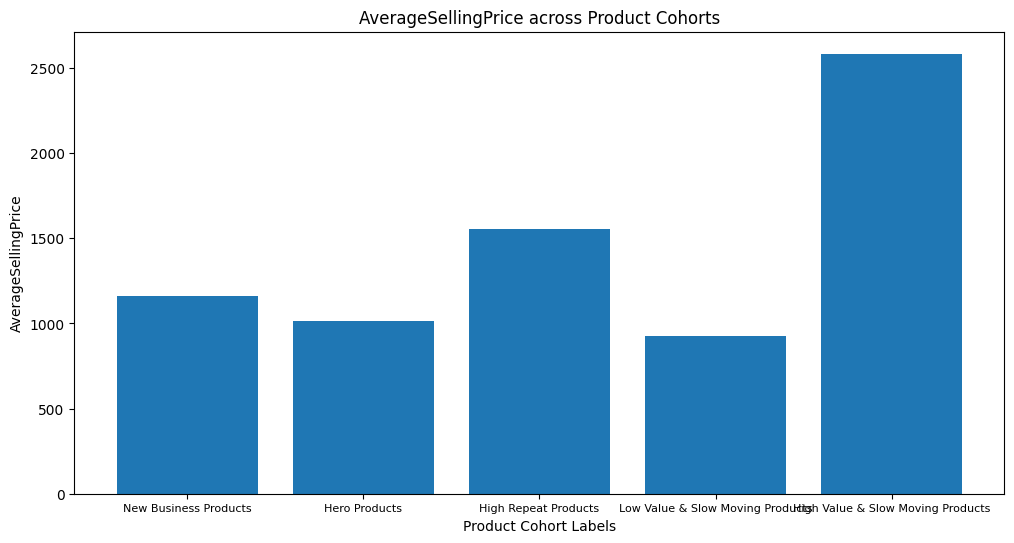

In [32]:
column_to_plot = 'AverageSellingPrice'
x_labels = p1['Product Cohort Lables']
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(x_labels, p1[column_to_plot])
plt.xlabel('Product Cohort Labels')
plt.ylabel(column_to_plot)
plt.title(f'{column_to_plot} across Product Cohorts')
plt.xticks(fontsize=8)
plt.show()

In [30]:
# #Visualization of cohorts with key parameters as axises
# fig = plt.figure(figsize = (15, 15))
# ax = plt.axes(projection ="3d")
# size=segstats['Users']*.05
# # Creating plot
# ax.scatter3D(segstats['CartPenetration'], segstats['NewUserRatio'],segstats['AverageSellingPrice'], s=size)
# plt.title("Product Cohort Distribution")
# ax.set_xlabel('CartPenetration', fontweight ='bold')
# ax.set_ylabel('NewUserRatio', fontweight ='bold')
# ax.set_zlabel('AverageSellingPrice', fontweight ='bold')
# for i in range(len(segstats)):
#      ax.text(segstats['CartPenetration'][i],
#                segstats['NewUserRatio'][i],
#              segstats['AverageSellingPrice'][i],
#                segstats['Product Cohort Lables'][i],
#                horizontalalignment='left',
#                rotation=25, wrap=True,
#                verticalalignment='center',
#                size='medium', color='black')
